# Трекинг движущихся объектов на конвейере
## Введение
Renue – IT-компании из Екатеринбурга, которая разрабатывает высоконагруженные и отказоустойчивые решения для крупных российских заказчиков, требуется создать решение для отслеживания и сортировки мусора на конвейере – выделять пластиковые бутылки в общем потоке предметов.

**Цель проекта:**  
Создать модель потокового трекинга пластиковой тары на конвейере, которая выдает координаты центра обнаруженных объектов для каждого видеокадра.
Скорость обработки потока должна быть не более 100 мс.
Метрика оценки модели –  *MOTA* (Multiple Object Tracking Accuracy).

**Данные:**
- Предобученная модель детекции пластиковых бутылок и код для ее запуска (пример).
- Датасет (изображения + разметка) в нескольких форматах: MOT, COCO, CVAT.
- Примеры видеозаписей работы конвейера

**Стек:**
- Python, Numpy, SciPy, PyTorch, OpenCV, Ultralytics, BoxMOT, MMTacking.

**Модели и алгоритмы (один из):**

- *SORT* (Simple Online and Realtime Tracking): простой и быстрый метод с хорошим компромиссом между точностью и скоростью.
- *Deep SORT*: улучшенная версия SORT, использующая глубокие нейронные сети для повышения точности.
- *ByteTrack*: современный алгоритм трекинга, известный своей высокой производительностью и точностью.
- *FairMOT* (Fair Multi-Object Tracking): подход, объединяющий детекцию и трекинг, что повышает точность и эффективность.
- *DEVA* (DEcoupled Video segmentation Approach): алгоритм трекинга, использующий методы ассоциации для надежного отслеживания объектов.
- *CSRT* (Discriminative Correlation Filter with Channel and Spatial Reliability): предлагается использовать для задач трекинга в реальном времени.

**План выполнения проекта:**
- Ознакомиться с данными и форматами датасетов.
- Изучить работу трекеров, выбрать подходящий и создать базовую модель.
- Обучить трекер.
- Дополниь решение сегментированием.
- Провести сравнительный анализ моделей и алгоритмов и предложить варианты улучшения решения.
- Протестировать итоговое решение и проанализировать результат.
- Подготовить доклад с описанием и выводами исследования.
- Выложить работу в репозиторий на GitHub с воспроизводимым кодом проекта, описанием и инструкцией по запуску в файле README.md и списком зависимостей в файле requirements.txt.

**Команда проекта:**
- Федор Сафонов  (TeamLead)
- Анна Йорданова
- Юрий Кашин
- Александр Вотинов
- Гульшат Зарипова
- Сергей Пашкин
- Александр Глазунов

## Подготовка библиотек, констант и функций

- Установим и импортируем нужные библиотеки.

In [1]:
#!pip install git+https://github.com/cheind/py-motmetrics.git -q

In [2]:
#!pip install motmetrics -q  # альтернативный вариант

In [3]:
#!pip install ultralytics -q

In [4]:
#!pip install torch torchvision -q

In [5]:
# Стандартные библиотеки
import os
import glob
import json
from time import time
from datetime import timedelta
from collections import defaultdict
from time import time
from datetime import timedelta

# Сторонние библиотеки
import numpy as np
import scipy
import cv2
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import motmetrics as mm
from PIL import Image
from IPython.display import Markdown, display

# Установка и подключение Ultraytics YOLO
import ultralytics
from ultralytics import YOLO
from ultralytics.utils import ops

In [6]:
# проверяем установку YOLO
ultralytics.checks()

Ultralytics YOLOv8.2.74  Python-3.9.5 torch-2.4.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Setup complete  (12 CPUs, 15.9 GB RAM, 126.4/150.0 GB disk)


- Зададим значения констант

In [7]:
# FPS для записи видео
FPS = 24

# индекс изображений, на которых проверяем модель
START = 1
STOP = 400

# выбор устройства для работы
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

- Укажем пути

In [8]:
# папки с размеченными изображениями
PATH_IMG = '../Datasets/images/images/'
PATH_TARGET = '../Datasets/mot_dataset/gt/gt.txt'

# папка с коротким видео
PATH_VIDEO = '../Video/31-03-2024-09%3A34%3A24_short.mp4'
PATH_VIDEO_BLUR = '../Video/30-03-2024-08%3A56%3A28_short_blur.mp4'

# папка с моделью
PATH_MODEL = '../Models/ultralytics/yolov10x_v2_4_best.pt'

# папка для выгрузки результатов работы
PATH_RESULTS = '../Results/'

# Создаем папку, если ее нет
if not os.path.exists(PATH_RESULTS):
    os.makedirs(PATH_RESULTS)
    print(f"Папка '{PATH_RESULTS}' была создана.")
else:
    print(f"Папка '{PATH_RESULTS}' уже существует.")

Папка '../Results/' уже существует.


- Опишем функции

In [9]:
def draw_track_and_boxes(annotated_frame, track_history, xy, wh, track_ids, gt=True):
    """
    Рисует историю треков объектов и bounding box (bbox) на аннотированном кадре, предоставляя визуализацию отслеживания объектов.

    Параметры:
    - annotated_frame (np.ndarray): Кадр, на который будут нанесены аннотации и треки.
    - track_history (dict): Словарь, содержащий историю треков для каждого объекта, где ключом является ID трека, а значением - список координат центра.
    - xy (list): Список координат верхнего левого угла боксов в формате [x, y].
    - wh (list): Список ширины и высоты боксов в формате [w, h].
    - track_ids (list): Список ID треков, соответствующих каждому бокс-объекту.
    - gt (bool): Флаг, указывающий, является ли это отображение истинным значением (ground truth). Если True, используется красный цвет для аннотаций.

    Функция выполняет следующие действия:
    1. Определяет цвет для аннотаций в зависимости от значения флага `gt`.
    2. Обрабатывает каждый трек, обновляя историю треков для соответствующего объекта.
    3. Рисует линию трека, если имеются хотя бы две его точки.
    4. Рисует bounding box вокруг объекта, если `gt` установлен в True.
    5. Ограничивает длину истории треков до 30 наиболее последних позиций.

    Примечание: Для корректного выполнения функции необходимо, чтобы все необходимые библиотеки (например, OpenCV и NumPy) были предварительно импортированы.
    """
    if gt:
        color = (0, 0, 255)  # Устанавливаем красный цвет для истинных значений (ground truth)
    else:
        color = (230, 230, 230)  # Устанавливаем светло-серый цвет для других объектов
        
    for xy_track, wh_track, track_id in zip(xy, wh, track_ids):
        x, y, w, h = xy_track[0], xy_track[1], wh_track[0], wh_track[1]  # Извлекаем координаты верхнего левого угла и размеры бокса
    
        track = track_history[track_id]  # Получаем историю трека для текущего объекта
        track.append((float(x+w/2), float(y+h/2)))  # Добавляем центральное положение бокса в историю трека
        if len(track) > 30:  # Ограничиваем длину истории треков до последних 30 позиций
            track.pop(0)  # Удаляем самую старую позицию из истории
            
        # Рисуем линии трека
        if len(track) > 1:  # Рисуем линию только если есть как минимум две точки в истории
            points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))  # Форматируем точки для рисования
            cv2.polylines(annotated_frame, [points], isClosed=False, color=color, thickness=3)  # Рисуем линию трека на аннотированном кадре
            
        if gt:
            cv2.rectangle(annotated_frame, (int(x), int(y)), (int(x + w), int(y + h)), color, 5)  # Рисуем bounding box для истинного значения (ground truth)

In [10]:
def track_objects_and_create_video(
    path_images,
    gt,
    model,
    path_results,
    output_video="output_video.mp4",
    imgsz=352,
    fps=FPS,
    start=START,
    device=DEVICE,
    need_show=False,
    need_save_video=True,
):
    """
    Обрабатывает набор изображений, выполняя отслеживание объектов с использованием модели YOLO и создает аннотированное видео.

    Параметры:
    - path_images (list): список строк с путями к изображениям (кадрам) для обработки.
    - gt (np.array): массив с истинными значениями (ground truth) объектов.
    - model (model): модель отслеживания объектов.
    - path_results (str): путь для сохранения выходных результатов (видеофайлов и JSON).
    - output_video (str): имя выходного видеофайла (по умолчанию 'output_video.mp4').
    - fps (int): количество кадров в секунду для выходного видео (по умолчанию 24).
    - start (int): начальный номер кадра (по умолчанию START).
    - device (torch.device): устройство, на котором проводятся расчеты.
    - need_show (bool): если True, отображает видео в окне во время обработки (по умолчанию False).
        Работает только при need_save_video=True.
    - need_save_video (bool): если True, то сохраняет аннотированное видео (по умолчанию True)

    Функция выполняет следующие действия:
    1. Инициализирует историю отслеживания для объектов и объектов во временном режиме (ground truth).
    2. Загружает первый кадр из списка изображений и определяет его размеры.
    3. Создает объект для записи видео с использованием указанного кодека и заданного FPS.
    4. Проходит по всем кадрам изображений по их путем:
        a. Загружает текущий кадр.
        b. Выполняет отслеживание объектов с использованием модели (например, YOLO).
        c. Если обнаружены объекты, получает их идентификаторы, координаты и размеры.
        d. Добавляет информацию об отслеживаемых объектах в список результатов.
        e. Визуализирует результаты (размеченные рамки) на текущем кадре.
        f. Если предоставлен ground truth (gt), добавляет его визуализацию.
        g. Добавляет номер кадра на аннотированный кадр.
        h. Сохраняет аннотированный кадр в выходное видео.
        i. Если параметр need_show установлен в True, отображает текущий аннотированный кадр.
        j. Позволяет прерывать выполнение функции при нажатии клавиши "q".
    5. Освобождает ресурсы: закрывает объект записи видео и уничтожает все окна OpenCV.
    6. Преобразует результаты отслеживания в массив и сохраняет их в формате JSON.
    7. Выводит сообщение о успешном сохранении данных в указанный файл JSON.

    Возвращает:
    - t (np.array): массив, содержащий информацию о отслеживаемых объектах.
    - delta_time_mean (float): среднее время расчета кадра.

    Примечание: Для корректного отображения аннотированного видео необходимо иметь установленные библиотеки OpenCV и YOLOv8.
    """
    
    # Создаем словари для хранения отслеживания и времени расчета
    track_history = defaultdict(lambda: [])
    track_history_gt = defaultdict(lambda: [])
    result_track = []
    time_list = []

    if need_save_video:
        # Читаем первый кадр изображения, чтобы получить его размеры
        frame = cv2.imread(path_images[0])
        height, width, _ = frame.shape
        
        # Определяем кодек для записи видео в формате MP4
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
        # Создаем объект для записи видео с заданными параметрами (путь, кодек, fps, размер)
        video_writer = cv2.VideoWriter(path_results + output_video, fourcc, fps, (width, height))
    
    # Проходим по всем изображениям и их индексам
    for frame_id, image_path in tqdm(enumerate(path_images)): 

        # фиксируем время начала обработки кадра
        start_time = time()
    
        # Читаем текущее изображение
        frame = cv2.imread(image_path)
        
        # Обновляем frame_id, начиная с заданного значения
        frame_id = frame_id + start

        # Выполнение отслеживания с помощью модели YOLOv8
        result = model.track(frame, persist=True, verbose=False, imgsz=imgsz, device=DEVICE)  # Выполняем отслеживание на CPU или GPU
        
        # Получаем результат отслеживания для первого результата (предполагается, что это будет YOLOv8)
        result_0 = result[0]
    
        # Проверяем, есть ли отслеживаемые объекты
        if result_0.boxes.id is None:
            continue  # Если объектов нет, переходим к следующему кадру
        
        # Получаем идентификаторы треков и координаты боксов объектов
        track_ids = result_0.boxes.id.int().cpu().tolist()  # Преобразуем идентификаторы в список
        xy = result_0.boxes.xyxy[:, :2].cpu()  # Получаем координаты верхнего левого угла боксов
        wh = result_0.boxes.xywh[:, 2:].cpu()  # Получаем ширину и высоту боксов
        conf = result_0.boxes.conf  # Получаем уверенность модели в распознавании объектов
        
        # Обрабатываем каждый отслеживаемый объект
        for i in range(len(track_ids)):
            # Добавляем информацию о треке в результат
            result_track.append((
                frame_id,              # Идентификатор текущего кадра
                track_ids[i],         # Идентификатор трек-идентификатора
                xy[i, 0].item(),      # X координата верхнего левого угла
                xy[i, 1].item(),      # Y координата верхнего левого угла
                wh[i, 0].item(),      # Ширина бокса
                wh[i, 1].item(),      # Высота бокса
                1,                     # Код состояния (например, 1 для активного)
                2,                     # Код типа объекта или другое значение (например, тип)
                conf[i].item()        # Уверенность модели (значение от 0 до 1)
            ))
    
        # Визуализация результатов на кадре
        annotated_frame = result_0.plot()
    
        draw_track_and_boxes(annotated_frame, track_history, xy, wh, track_ids, gt=False)

        if gt is not None:
            track_ids_gt = gt[gt[:,0]==frame_id,1]
            xy_gt = gt[gt[:,0]==frame_id,2:4]
            wh_gt = gt[gt[:,0]==frame_id,4:6]
            
            draw_track_and_boxes(annotated_frame, track_history_gt, xy_gt, wh_gt, track_ids_gt)

        # Добавление номера кадра в верхний правый угол
        cv2.putText(annotated_frame, f"Frame: {frame_id}", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
        cv2.putText(annotated_frame, 'True', (50, 250), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
        cv2.putText(annotated_frame, 'Pred', (50, 300), cv2.FONT_HERSHEY_SIMPLEX, 2, (230, 230, 230), 2)

        stop_time = time()
        detla_time = timedelta(seconds=stop_time-start_time)
        time_list.append(detla_time)

        if need_save_video:
            # Сохранение аннотированного кадра в видео
            video_writer.write(annotated_frame)
    
            # Отображение аннотированного кадра
        if need_show:
            cv2.imshow("YOLOv8 Tracking", annotated_frame)
    
            # Условие выхода при нажатии "q"
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break

    if need_save_video:
        # Освобождаем ресурсы
        video_writer.release()  # Закрываем писатель видео
        cv2.destroyAllWindows()

    t = np.array(result_track)

    # Преобразование в список для совместимости с JSON
    t_list = t.tolist()

    # Расчитываем среднее время обработки кадра
    delta_time_mean = round(np.mean(time_list).total_seconds(), 4)
    
    # Сохранение в JSON файл
    with open(path_results + f'pred_track_{START}_{STOP}.json', 'w') as json_file:
        json.dump(t_list, json_file)
    
    print(f"Данные успешно сохранены в {path_results}'pred_track_{START}_{STOP}.json")

    # Сохранение t_list в другой JSON файл
    with open(path_results + f'delta_time_mean_{START}_{STOP}.json', 'w') as json_file:
        json.dump(delta_time_mean, json_file)
    
    print(f"Данные успешно сохранены в {path_results}'delta_time_mean_{START}_{STOP}.json")

    return t, delta_time_mean

In [11]:
def track_objects_on_video_and_create_video(
    video_path,
    gt,
    model,
    path_results,
    name_suffix,
    output_video="output_video.mp4",
    imgsz=352,
    fps=FPS,
    device=DEVICE,
    need_show=False,
    need_save_video=True,
):
    
    """
    Функция для отслеживания объектов на видео с помощью заданной модели и создания аннотированного видео.

    Параметры:
    - video_path (str): Путь к входному видеофайлу.
    - gt (np.array): Ground truth (проверка истинного значения) в виде массива, или None.
    - model (model): Модель отслеживания объектов.
    - path_results (str): Путь для сохранения выходных результатов.
    - name_suffix (str): Суффикс для имен выходных файлов.
    - output_video (str): Имя выходного видеофайла (по умолчанию 'output_video.mp4').
    - fps (int): Частота кадров для выходного видео (по умолчанию 24).
    - device (torch.device): Устройство (CPU/GPU) для выполнения (по умолчанию DEVICE).
    - need_show (bool): если True, отображает видео в окне во время обработки (по умолчанию False).
        Работает только при need_save_video=True.
    - need_save_video (bool): если True, то сохраняет аннотированное видео (по умолчанию True)

    Функция выполняет следующие действия:
    1. Инициализирует историю отслеживания для объектов и объектов во временном режиме (ground truth).
    2. Создает объект для записи видео с использованием указанного кодека и заданного FPS.
    3. Проходит по всем кадрам изображений по их путем:
        a. Загружает текущий кадр.
        b. Выполняет отслеживание объектов с использованием модели (например, YOLOv8).
        c. Если обнаружены объекты, получает их идентификаторы, координаты и размеры.
        d. Добавляет информацию об отслеживаемых объектах в список результатов.
        e. Визуализирует результаты (размеченные рамки) на текущем кадре.
        f. Если предоставлен ground truth (gt), добавляет его визуализацию.
        g. Добавляет номер кадра на аннотированный кадр.
        h. Сохраняет аннотированный кадр в выходное видео.
        i. Если параметр need_show установлен в True, отображает текущий аннотированный кадр.
        j. Позволяет прерывать выполнение функции при нажатии клавиши "q".
    4. Освобождает ресурсы: закрывает объект записи видео и уничтожает все окна OpenCV.
    5. Преобразует результаты отслеживания в массив и сохраняет их в формате JSON.
    6. Выводит сообщение о успешном сохранении данных в указанный файл JSON.
    
    Возвращает:
    - t (np.array): Массив с результатами отслеживания.
    - delta_time_mean (float): Среднее время обработки каждого кадра.
    """
    
    # Создаем словари для хранения отслеживания и времени расчета
    track_history = defaultdict(lambda: [])
    track_history_gt = defaultdict(lambda: [])
    result_track = []
    time_list = []

    # Открываем видео
    cap = cv2.VideoCapture(video_path)

    if need_save_video:
        
        # Получаем параметры видео (ширина, высота)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        # Настраиваем видеописатель для сохранения выходного видео
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
        video_writer = cv2.VideoWriter(path_results + output_video, fourcc, fps, (width, height))
    
    frame_id = 0  # Идентификатор текущего кадра
    
    while cap.isOpened():  # Цикл, пока видео открыто
        ret, frame = cap.read()  # Читаем текущий кадр

        frame_id += 1  # Увеличиваем идентификатор кадра
        
        if not ret:
            break  # Выход из цикла, если не удалось прочитать кадр

        # Обработка кадра
        start_time = time()  # Запоминаем время начала обработки кадра

        result = model.track(frame, persist=True, verbose=False, imgsz=imgsz, device=DEVICE)  # Запуск модели отслеживания
        result_0 = result[0]
    
        if result_0.boxes.id is None:
            continue  # Пропускаем кадр, если ID объектов отсутствуют
        
        # Получаем данные о треках
        track_ids = result_0.boxes.id.int().cpu().tolist() 
        xy = result_0.boxes.xyxy[:, :2].cpu() 
        wh = result_0.boxes.xywh[:, 2:].cpu()  
        conf = result_0.boxes.conf
        
        # Сохраняем результаты отслеживания в список
        for i in range(len(track_ids)):
            result_track.append((
                frame_id,            
                track_ids[i],
                xy[i, 0].item(),
                xy[i, 1].item(),
                wh[i, 0].item(), 
                wh[i, 1].item(),
                1,
                2, 
                conf[i].item()
            ))

        if need_save_video:
            annotated_frame = result_0.plot()  # Аннотируем кадр с результатами
        
            # Рисуем треки и bounding boxes
            draw_track_and_boxes(annotated_frame, track_history, xy, wh, track_ids, gt=False)
    
            # Если есть ground truth, рисуем его
            if gt is not None:
                track_ids_gt = gt[gt[:,0]==frame_id,1]
                xy_gt = gt[gt[:,0]==frame_id,2:4]
                wh_gt = gt[gt[:,0]==frame_id,4:6]
                
                draw_track_and_boxes(annotated_frame, track_history_gt, xy_gt, wh_gt, track_ids_gt)
    
            # Добавляем текст на кадр с идентификатором кадра и метками
            cv2.putText(annotated_frame, f"Frame: {frame_id}", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
            cv2.putText(annotated_frame, 'True', (50, 250), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
            cv2.putText(annotated_frame, 'Pred', (50, 300), cv2.FONT_HERSHEY_SIMPLEX, 2, (230, 230, 230), 2)

        stop_time = time()  # Запоминаем время окончания обработки кадра
        delta_time = timedelta(seconds=stop_time - start_time)  # Вычисляем время обработки кадра
        time_list.append(delta_time)  # Сохраняем время в список
        
        if need_save_video:
            # Сохранение аннотированного кадра в выходное видео
            video_writer.write(annotated_frame)
    
            # Отображение аннотированного кадра
        if need_show:
            cv2.imshow("Tracking", annotated_frame)
    
            # Условие выхода при нажатии кнопки "q"
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break

    if need_save_video:
        # Освобождаем ресурсы
        cap.release()  # Закрываем видеопоток
        video_writer.release()  # Закрываем писатель видео
        cv2.destroyAllWindows()  # Удаляем все окна OpenCV

    t = np.array(result_track)  # Преобразуем результаты отслеживания в массив NumPy

    # Преобразование в список для совместимости с JSON
    t_list = t.tolist()

    # Расчитываем среднее время обработки кадра
    delta_time_mean = round(np.mean(time_list).total_seconds(), 4)
    
    # Сохранение результатов отслеживания в JSON файл
    with open(path_results + f'pred_track_{name_suffix}.json', 'w') as json_file:
        json.dump(t_list, json_file)
    
    print(f"Данные успешно сохранены в {path_results}'pred_track_{name_suffix}.json")

    # Сохранение t_list в другой JSON файл, если это необходимо
    with open(path_results + f'delta_time_mean_{name_suffix}.json', 'w') as json_file:
        json.dump(delta_time_mean, json_file)
    
    print(f"Данные успешно сохранены в {path_results}'delta_time_mean_{name_suffix}.json")

    return t, delta_time_mean # Возвращаем результаты и среднее время обработки кадров

In [12]:
def mot_metrics_enhanced_calculator(gt, t, stop=STOP):
    """
    Вычисляет метрики отслеживания объектов (MOT) на основе данных о истинных значениях и результатах отслеживания 
    с использованием методов отслеживания. Функция отслеживает изменения метрик по кадрам.

    Параметры:
        gt (np.array): Массив, содержащий истинные значения (ground truth) в формате, 
                         где каждая строка представляет объект в формате [frame_id, object_id, x1, y1, x2, y2].
        t (np.array): Массив результатами отслеживания (tracking results) в формате, 
                        аналогичном gt_source.

    Функция выполняет следующие действия:
        1. Загружает данные о истинных значениях и результатах отслеживания из файлов CSV.
        2. Инициализирует накопитель метрик для отслеживания.
        3. Проходит по каждому кадру в заданном диапазоне.
        4. Извлекает детекции истинных значений и детекции алгоритма для текущего кадра.
        5. Вычисляет матрицу дистанций (IoU) между истинными значениями и результатами отслеживания.
        6. Обновляет накопленные метрики на основе текущих детекций.
        7. Вычисляет метрики для текущего кадра.
        8. Сохраняет результаты метрик по кадрам для последующего анализа.
        9. Форматирует и отображает сводную строку со значениями метрик.

    Возвращает:
        tuple: Кортеж, состоящий из:
            - strsummary (str): Итоговые значения метрик (Recall, Precision, MOTA, MOTP).
            - summary_hist (list): История изменения метрик.
            - acc (motmetrics.mot.MOTAccumulator): Аккумулятор метрик.

    Примечание:
        Функция использует библиотеки для оценки отслеживания (например, `motmetrics`) и 
        предполагает, что данные в файлах корректно отформатированы. 
        Изменения в метриках отслеживания сохраняются по кадрам, что позволяет анализировать 
        производительность алгоритма во времени.
    """
    
    # Инициализируем список для хранения сводных данных по кадрам
    summary_hist = []

    # Инициализируем накопитель метрик
    acc = mm.MOTAccumulator(auto_id=True)

    # Списки для хранения метрик по кадрам
    recall_list = []
    precision_list = []
    mota_list = []
    motp_list = []
    frames = []

    # Проходим по каждому кадру в заданном диапазоне
    for frame in range(START, stop):
        
        # Извлекаем детекции для истинных значений и результатов отслеживания
        gt_dets = gt[gt[:, 0] == frame, 1:6]
        t_dets = t[t[:, 0] == frame, 1:6]
        
        # Вычисляем матрицу дистанций (IoU) между истинными значениями и результатами отслеживания
        C = mm.distances.iou_matrix(gt_dets[:, 1:], t_dets[:, 1:], max_iou=0.5)

        # Обновляем накопленные метрики на основе текущих детекций
        acc.update(
            gt_dets[:, 0].astype("int").tolist(), t_dets[:, 0].astype("int").tolist(), C
        )
        
        # Сохраняем текущий кадр
        frames.append(frame)

        # Вычисляем метрики для текущего кадра
        summary = mm.metrics.create().compute(
            acc, metrics=["recall", "precision", "mota", "motp"], name="acc"
        )

        # Создаем объект метрик
        mh = mm.metrics.create()
        # Вычисляем метрики
        summary = mh.compute(
            acc, metrics=["recall", "precision", "mota", "motp"], name="acc"
        )
        # Сохраняем сводные данные для текущего кадра
        summary_hist.append(summary)
        
    # Отображаем итоговые результаты
    strsummary = mm.io.render_summary(
            summary,
            namemap={
                "recall": "Recall",
                "precision": "Precision",
                "mota": "MOTA",
                "motp": "MOTP",
            },
        )

    # Возвращаем итоговые метрики и сводные данные
    return strsummary, summary_hist, acc

In [13]:
def analyze_metrics(summary_hist,):
    """
    Функция для анализа метрик отслеживания объектов и построения графиков их значений по временным кадрам.

    Параметры:
    summary_hist (list): Список DataFrame объектов, где каждый DataFrame содержит метрики 
                         (recall, precision, MOTA, MOTP) для соответствующего кадра. 
                         Предполагается, что каждая метрика представлена в первой строке 
                         каждого DataFrame.

    Функция выполняет следующие действия:
    1. Инициализирует словарь для хранения значений метрик.
    2. Обходит список DataFrame объектов summary_hist, извлекая значения метрик 
       для каждого кадра.
    3. Подготавливает временные метки (кадры) для графиков.
    4. Строит и отображает графики для каждой из метрик (recall, precision, MOTA, MOTP).

    Возвращает:
    None: Функция не возвращает значений, но визуализирует результаты в виде графиков для каждого из показателей.

    Примечание:
    Графики отображают изменения значений метрик по кадрам, что позволяет оценить 
    производительность алгоритма отслеживания объектов во времени.
    """

    # Задаем названия метрик для анализа
    metrics = ['recall', 'precision', 'mota', 'motp']
    metric_names = ['Recall', 'Precision', 'MOTA', 'MOTP']
    
    # Инициализируем словарь для хранения данных метрик
    data = {metric: [] for metric in metrics}
    frames = []

    # Проходим по каждому кадру и извлекаем метрики
    for frame, summary in enumerate(summary_hist):
        frames.append(frame + START)  # Добавляем номер кадра в список
        for metric in metrics:
            # Извлекаем значение метрики и добавляем его в соответствующий список
            data[metric].append(summary.iloc[0][metric])
    
    # Построение графиков
    plt.figure(figsize=(12, 8))
    
    # Для каждой метрики создаем подграфик
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)
        plt.plot(frames, data[metric], marker='.', label=metric_names[i])  # Строим график
        plt.title(f'{metric_names[i]} по кадрам')  # Заголовок графика
        plt.xlabel('Кадр')  # Подпись оси x
        plt.ylabel(metric_names[i])  # Подпись оси y
        plt.xticks(frames[::20], rotation=45)  # Устанавливаем метки на оси x
        plt.grid()  # Включаем сетку на графиках

    plt.tight_layout()  # Автоматически настраиваем размещение графиков
    plt.show()  # Отображаем графики

## Запуск бэйзлайна

Первый шаг - запустить бейзлайновое решение и посмотреть, как оно работает с предоставленными данными. Запустим предобученную модель `YOLO` на коротком видео.

In [14]:
# загружаем предобученную модель детектора YOLOv10 
model_demo = YOLO(PATH_MODEL) 

In [15]:
# открываем видеофайл
cap = cv2.VideoCapture(PATH_VIDEO)

# сохраняем историю трекинга 
track_history = defaultdict(lambda: [])

# перебираем видеокадры 
while cap.isOpened():
    # читаем каждый кадр видео
    success, frame = cap.read()

    if success:
        # запускаем отслеживание YOLOv10 для каждого кадра, сохраняя треки между кадрами
        results = model_demo.track(frame, persist=True, vid_stride=1, imgsz=352, verbose=False)

        # получаем значения boxes и track IDs
        boxes = results[0].boxes.xywh
        track_ids = results[0].boxes.id.int().tolist() 

        # визуализируем результаты в кадре
        annotated_frame = results[0].plot()

        # строим треки
        for box, track_id in zip(boxes, track_ids):
            x, y, w, h = box
            track = track_history[track_id]
            track.append((float(x), float(y)))  # x, y координаты центральной точки 
            if len(track) > 30:  # сохраняем дроожки для треков
                track.pop(0)

            # рисуем линии треков
            points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
            cv2.polylines(annotated_frame, [points], isClosed=False, color=(230, 230, 230), thickness=10)

        # отображаем аннотацию в кадре
        cv2.imshow("YOLOv10 Tracking", annotated_frame)

        # разрываем цикл при нажатии клавишы "q"
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # разрываем цикл при окончании видео 
        break

# освобождаем объект видеозахвата и закрываем окно отображения 
cap.release()
cv2.destroyAllWindows()

### Вывод по первым двум шагам

- Обновили и загрузили библиотеки.
- Загрузили модель.
- Проверили работу модели, запустив визуализацию детекции и трекинга на видеопотоке: модель обнаруживает объекты и строит треки.

Теперь построим визуализацию предсказаных bbox и треков, проведем анализ ошибок модели и метрик.

## Анализ базовой модели на картинках.

Проверим работу модели на примере первых 400 изображений, визуализируем предсказания модели и реальную разметку, посмотрим, как ведут себя метрики. Наша функция `track_objects_and_create_video` позволяет выбирать срез изображений от `START` до `STOP`, что даёт возможность выбирать любой промежуток видео для анализа. В перспективе, если нам попадётся участок видео, на котором значительно падает метрика, то можно подробно его изучить.

Создадим список путей изображений.

In [16]:
image_paths = sorted(
    glob.glob(f'{PATH_IMG}{str(i).zfill(6)}.jpg') 
    for i in range(START, STOP + 1)
)

image_paths = [path for sublist in image_paths for path in sublist]

Создадим срез `gt_slice`.

In [17]:
gt = np.loadtxt(PATH_TARGET, delimiter=",")
gt_slice = gt[(gt[:, 0] <= STOP) & (gt[:, 0] >= START)]

Загрузим новую модель.

In [18]:
model_img = YOLO(PATH_MODEL) 

Попробуем загрузить результаты, если они уже были посчитаны, если нет, то создадим их.

In [19]:
try:
    with open(PATH_RESULTS + f"pred_track_{START}_{STOP}.json", "r") as json_file:
        t = np.array(json.load(json_file))
    with open(PATH_RESULTS + f"delta_time_mean_{START}_{STOP}.json", "r") as json_file:
        time_per_frame = json.load(json_file)
    print("Данные успешно загружены")

except:
    print("Выполняется расчет")
    t, time_per_frame = track_objects_and_create_video(
        image_paths,
        gt_slice,
        model_img,
        PATH_RESULTS,
        output_video=f"output_video_{START}_{STOP}.mp4",
        fps=FPS,
    )

Данные успешно загружены


Посмотрим на время обработки одного кадра.

In [20]:
display(Markdown(f'Время обработки одного кадра: **{time_per_frame}**'))

Время обработки одного кадра: **0.1515**

Расcчитаем метрики, выведем графики изменения метрики.

In [21]:
strsummary, summary_hist, acc = mot_metrics_enhanced_calculator(gt_slice, t)

In [22]:
print(strsummary)

       Recall  Precision      MOTA      MOTP
acc  0.917341        1.0  0.912139  0.099635


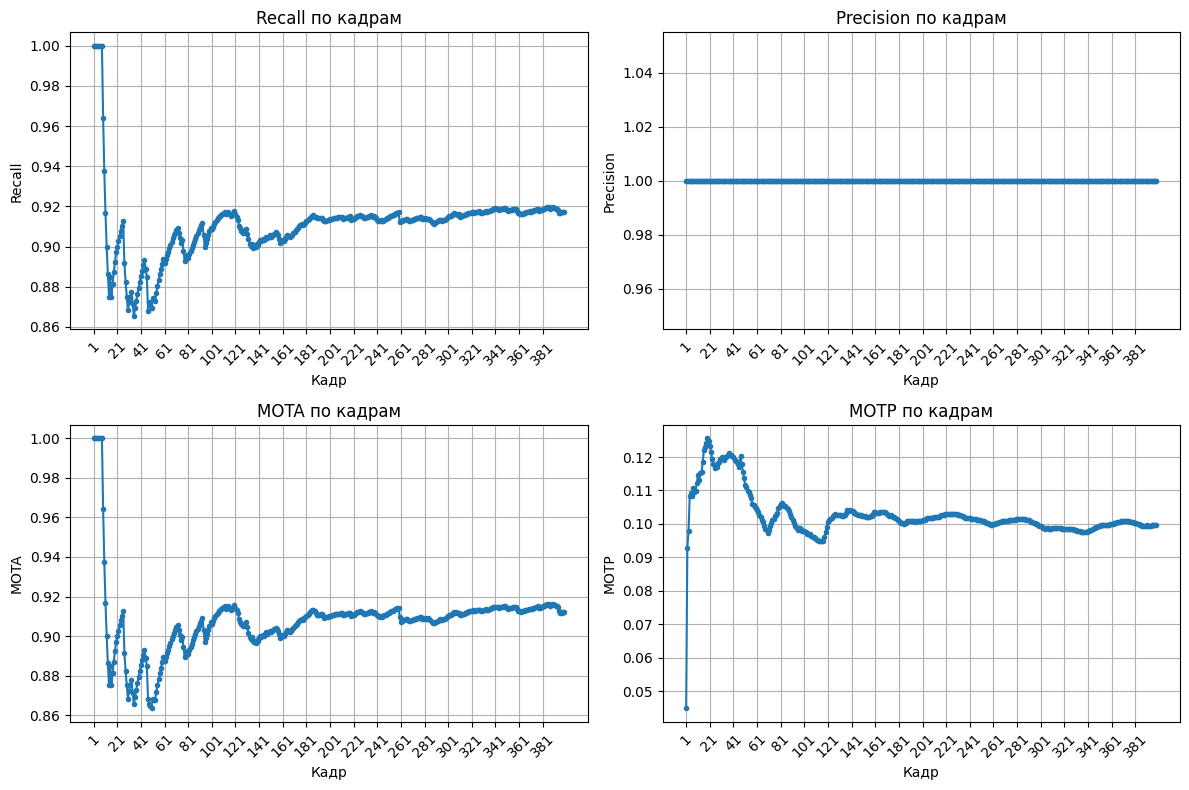

In [23]:
analyze_metrics(summary_hist)

Неплохое значение метрик, сложно выделить промежуток для анализа. Посмотрим, как будут вести себя метрики на всех 9000 кадрах.

## Метрика по всем 9000 кадрам

In [24]:
STOP = 9000

In [25]:
image_paths = sorted(
    glob.glob(f'{PATH_IMG}{str(i).zfill(6)}.jpg') 
    for i in range(START, STOP + 1)
)

image_paths = [path for sublist in image_paths for path in sublist]

In [26]:
model_img_9000 = YOLO(PATH_MODEL) 

In [27]:
try:
    with open(PATH_RESULTS + f"pred_track{START}_{STOP}.json", "r") as json_file:
        t_9000 = np.array(json.load(json_file))
    with open(PATH_RESULTS + f"time_{START}_{STOP}.json", "r") as json_file:
        time_9000 = np.array(json.load(json_file))
    print(f"Данные успешно загружены")

except:
    t_9000, time_per_frame_9000 = track_objects_and_create_video(
        image_paths,
        gt,
        model_img_9000,
        PATH_RESULTS,
        output_video=f"output_video_{START}_{STOP}.mp4",
        need_save_video=False,
    )

0it [00:00, ?it/s]

Данные успешно сохранены в ../Results/'pred_track_1_9000.json
Данные успешно сохранены в ../Results/'delta_time_mean_1_9000.json


In [28]:
display(Markdown(f'Время обработки одного кадра: **{time_per_frame_9000}**'))

Время обработки одного кадра: **0.1438**

In [29]:
strsummary_9000, summary_hist_9000, acc_9000 = mot_metrics_enhanced_calculator(gt, t_9000)

In [30]:
print(strsummary_9000)

       Recall  Precision      MOTA      MOTP
acc  0.917341        1.0  0.912139  0.099635


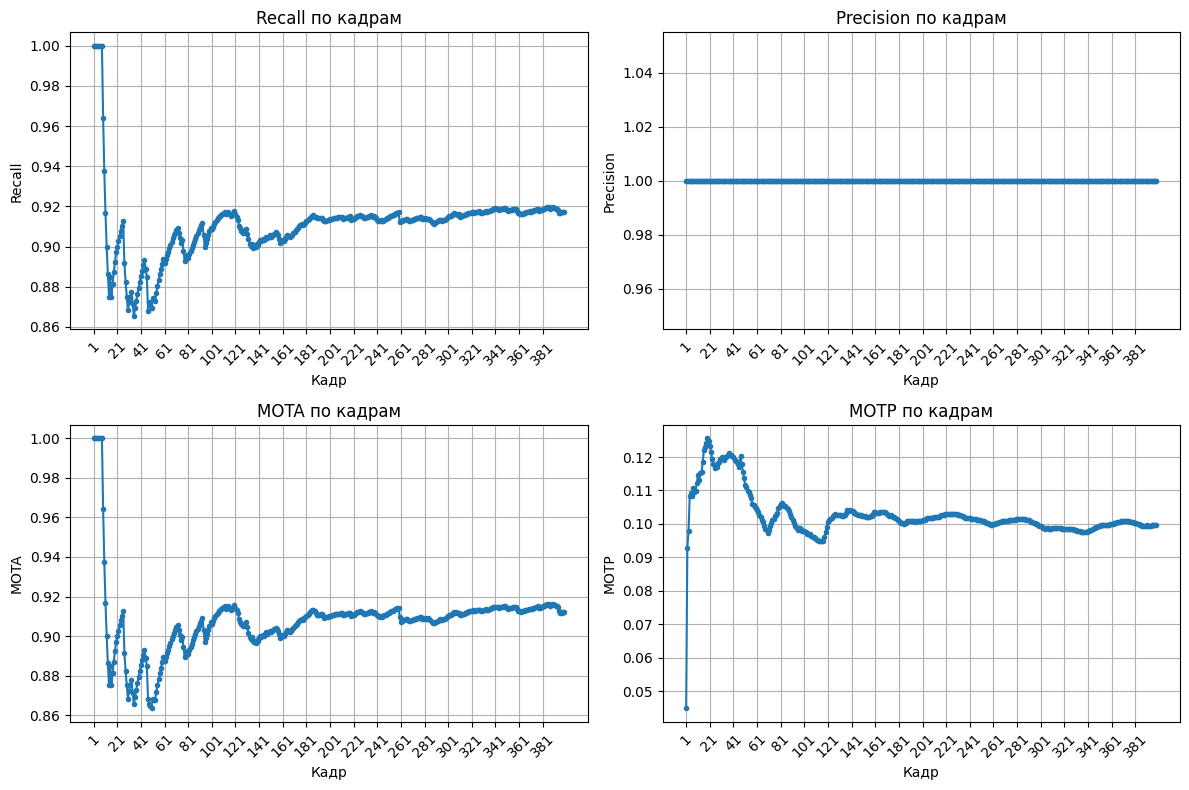

In [31]:
analyze_metrics(summary_hist_9000)

Метрика держится стабильно. Теперь запустим модель в более приближенным к реальным условиях. Передадим ей видео длиной 8 секунд и имеющее 99 кадров.

## Создание видео с разметкой

Задаим суффикс названию видео для сохранения видео с разметкой и количество кадров.

In [32]:
name_suffix = 'short'
num_fames = 99

Создадим срез `gt` разметки.

In [33]:
gt_video_short = gt[gt[:, 0] <= num_fames]

Зададим модель.

In [34]:
model_video = YOLO(PATH_MODEL)

Попробуем загрузить результаты, если они уже были посчитаны, если нет, то создадим их.

In [35]:
try:
    with open(PATH_RESULTS + f"pred_track_{name_suffix}.json", "r") as json_file:
        t_video_short = np.array(json.load(json_file))
    with open(PATH_RESULTS + f"delta_time_mean_{name_suffix}.json", "r") as json_file:
        time_video_short = json.load(json_file)
    print("Данные успешно загружены")

except:
    print("Выполняется расчет")
    t_video_short, time_per_frame_video_short = track_objects_on_video_and_create_video(
        PATH_VIDEO,
        gt,
        model_video,
        PATH_RESULTS,
        name_suffix,
        output_video=f"output_video_{name_suffix}.mp4",
    )

Выполняется расчет
Данные успешно сохранены в ../Results/'pred_track_short.json
Данные успешно сохранены в ../Results/'delta_time_mean_short.json


In [36]:
display(Markdown(f'Время обработки одного кадра: **{time_per_frame_video_short}**'))

Время обработки одного кадра: **0.1025**

In [37]:
strsummary_video_short, summary_hist_video_short, acc_video_short = mot_metrics_enhanced_calculator(gt_video_short, t_video_short, stop=num_fames)

In [38]:
print(strsummary_video_short)

       Recall  Precision      MOTA      MOTP
acc  0.905707        1.0  0.903226  0.098918


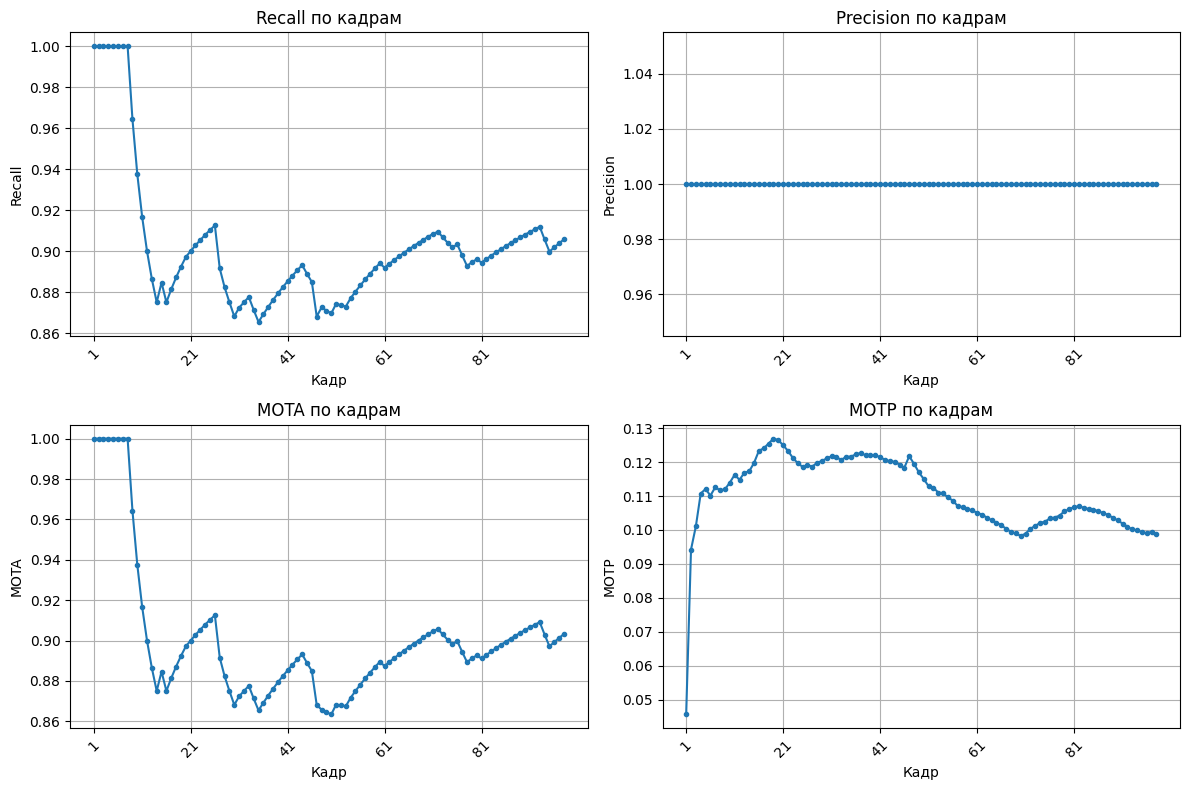

In [39]:
analyze_metrics(summary_hist_video_short)

Метрики аналогичны, полученным ранее. Проверим, влияет ли на время работы сохранение видео и выполнение функции отрисовки аннотаций, так как при сортировке мусора от нашей модели не требуется выполнять данные действия. Передадим в параметр `need_save_video` значение `False`.

### Время работы без сохранения видео и аннотирования видео

In [40]:
t_video_short, time_per_frame_video_short = track_objects_on_video_and_create_video(
    PATH_VIDEO,
    gt,
    model_video,
    PATH_RESULTS,
    name_suffix,
    output_video=f"output_video_{name_suffix}.mp4",
    need_save_video=False,
)

Данные успешно сохранены в ../Results/'pred_track_short.json
Данные успешно сохранены в ../Results/'delta_time_mean_short.json


In [41]:
display(Markdown(f'Время обработки одного кадра: **{time_per_frame_video_short}**'))

Время обработки одного кадра: **0.0789**

Разница не сильно заметна. Посмотрим, как наша модель распознаёт объекты на смазанном видео.

## Просмотр смазанного видео

In [42]:
name_suffix = 'short_blur'

In [43]:
model_video = YOLO(PATH_MODEL) 

In [44]:
gt_blur = None

In [45]:
try:
    with open(PATH_RESULTS + f"pred_track_{name_suffix}.json", "r") as json_file:
        t_video_short = np.array(json.load(json_file))
    with open(PATH_RESULTS + f"delta_time_mean_{name_suffix}.json", "r") as json_file:
        time_video_short = json.load(json_file)
    print("Данные успешно загружены")

except:
    print("Выполняется расчет")
    t_video_short_blur, time_per_frame_video_short_blur = track_objects_on_video_and_create_video(
        PATH_VIDEO_BLUR,
        gt_blur,
        model_video,
        PATH_RESULTS,
        name_suffix,
        output_video=f"output_video_{name_suffix}.mp4",
    )

Выполняется расчет
Данные успешно сохранены в ../Results/'pred_track_short_blur.json
Данные успешно сохранены в ../Results/'delta_time_mean_short_blur.json


In [46]:
t_video_short_blur, time_per_frame_video_short_blur = track_objects_on_video_and_create_video(
    PATH_VIDEO_BLUR,
    gt_blur,
    model_video,
    PATH_RESULTS,
    name_suffix,
    output_video=f"output_video_{name_suffix}.mp4")

Данные успешно сохранены в ../Results/'pred_track_short_blur.json
Данные успешно сохранены в ../Results/'delta_time_mean_short_blur.json


In [47]:
display(Markdown(f'Время обработки одного кадра: **{time_per_frame_video_short_blur}**'))

Время обработки одного кадра: **0.0893**

### Вывод по второму этапу

- Построили базовую модель трекинга.
- Проверили работу модели на 400 изображениях и на 8 секундном видео.
- Размер изображения(imgsz) установили 352.
- Метрика MOTA составила 0.912409.